# Predicting Presence of Heart Disease

Christopher Simms 59032219

Juhi Grover 76008424

Etan Huang 29998721

Wendy Wang 38122164

## Introduction

Heart disease refers to various conditions that affect the heart, including blood vessel disease, irregular heartbeats, heart valve disease, etc.

"Heart disease is responsible for most deaths worldwide for both men and women of all races, accounting for about 1 in every 4 deaths." (Thomas 2020 - Healthline.com), making it one of the major causes of death. Heart disease is sometimes referred to as “silent” because, in many cases, it is not diagnosed until the individual experiences signs or symptoms of a heart attack or heart failure. Being such a major cause of death, usually through heart attacks, it would be very helpful if we could identify those with the condition before too many symptoms have a chance to manifest.

Since it is difficult to diagnose heart disease before more severe symptoms start to appear, our goal is to predict heart disease diagnosis based on known risk factors like high blood pressure and high cholesterol, so that heart disease can be caught even before symptoms start to appear. By detecting heart disease before symptoms begin to appear, patients can receive the right treatment ahead of time and have a greater chance of survival. Looking online, there are many identified risk factors, which include obesity, diabetes and high blood pressure, among other conditions and lifestyle habits. How can we be sure which of these risk factors significantly increase chances of heart disease, and by how much do they increase the risk?

The dataset we are using is a Heart Disease Data Set (Janosi et al.) that contains information about a person's age, sex, other medical factors and whether the individual was diagnosed with heart disease. The dataset contains 13 variables for which observations were collected and a diagnosis column which is the categorical class we are predicting.

## Method

Out of the 13 variables in our dataset, five were numerical. We chose to use four of these five: age, max heart rate, resting blood pressure and cholesterol levels. The fifth, which looks at ST wave depressions caused by exercise, was omitted because it is too complex for our needs, and correctly interpreting its meaning requires significant understanding of the biology of the heart.

In order to predict the presence of heart disease, we will use a classification model, trained on the four predictor variables mentioned above. One way we plan to visualize the results is using scatter plots comparing two predictors, with data points colored by diagnosis, and a background color indicating the prediction of the classifier (end of section 5.8 in the textbook).

In [1]:
#run this cell before continuing
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

### Data Tidying ###

We begin by importing our dataset and assigning names to the columns, which are given on the <a href=https://archive.ics.uci.edu/ml/datasets/Heart+Disease>dataset's website<a> but not included in the file. We also set many of the predictor variables to factors, since they are incorrectly imported as numeric.

In [2]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
heart_disease_import <- read_csv(url, 
                               col_names=c("age",
                                           "sex",
                                           "chest_pain_type",
                                           "resting_blood_pressure",
                                           "cholesterol_level",
                                           "high_fasting_blood_sugar",
                                           "resting_ecg_results",
                                           "max_heart_rate",
                                           "exercise_induced_angina",
                                           "ST_depression_induced_by_exercise",
                                           "slope_of_peak_exercise_ST_segment",
                                           "num_blood_vessels_colored",
                                           "thal",
                                           "diagnosis_old"))

mutated_heart_disease <- heart_disease_import |>
                        mutate(sex = as_factor(sex)) |>
                        mutate(chest_pain_type = as_factor(chest_pain_type)) |>
                        mutate(high_fasting_blood_sugar = as_factor(high_fasting_blood_sugar)) |>
                        mutate(resting_ecg_results = as_factor(resting_ecg_results)) |>
                        mutate(exercise_induced_angina = as_factor(exercise_induced_angina)) |>
                        mutate(slope_of_peak_exercise_ST_segment = as_factor(slope_of_peak_exercise_ST_segment)) |>
                        mutate(num_blood_vessels_colored = as_factor(num_blood_vessels_colored)) |>
                        mutate(thal = as_factor(thal))

mutated_heart_disease

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): num_blood_vessels_colored, thal
dbl (12): age, sex, chest_pain_type, resting_blood_pressure, cholesterol_lev...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,chest_pain_type,resting_blood_pressure,cholesterol_level,high_fasting_blood_sugar,resting_ecg_results,max_heart_rate,exercise_induced_angina,ST_depression_induced_by_exercise,slope_of_peak_exercise_ST_segment,num_blood_vessels_colored,thal,diagnosis_old
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


### Adding a New Diagnosis Column

Before continuing, we need to add a new diagnosis column, which we will do below. This is because the dataset's diagnosis column includes values from 0 to 4, but the website comments that all analyses done on the dataset only tried to detect the presence of heart disease, not the severity (which is indicated by the values between 1 and 4). Because of this, we will mutate a new column named "diagnosis" that has a 1 for every nonzero value in the old diagnosis column.

In [3]:
heart_disease_data <- mutated_heart_disease |>
                mutate(diagnosis= ifelse(diagnosis_old>0,1,0)) |>
                mutate(diagnosis_old = as_factor(diagnosis_old)) |>
                mutate(diagnosis = as_factor(diagnosis))
heart_disease_data

age,sex,chest_pain_type,resting_blood_pressure,cholesterol_level,high_fasting_blood_sugar,resting_ecg_results,max_heart_rate,exercise_induced_angina,ST_depression_induced_by_exercise,slope_of_peak_exercise_ST_segment,num_blood_vessels_colored,thal,diagnosis_old,diagnosis
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2,1
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3,1
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0,0


### Exploratory Data Analysis

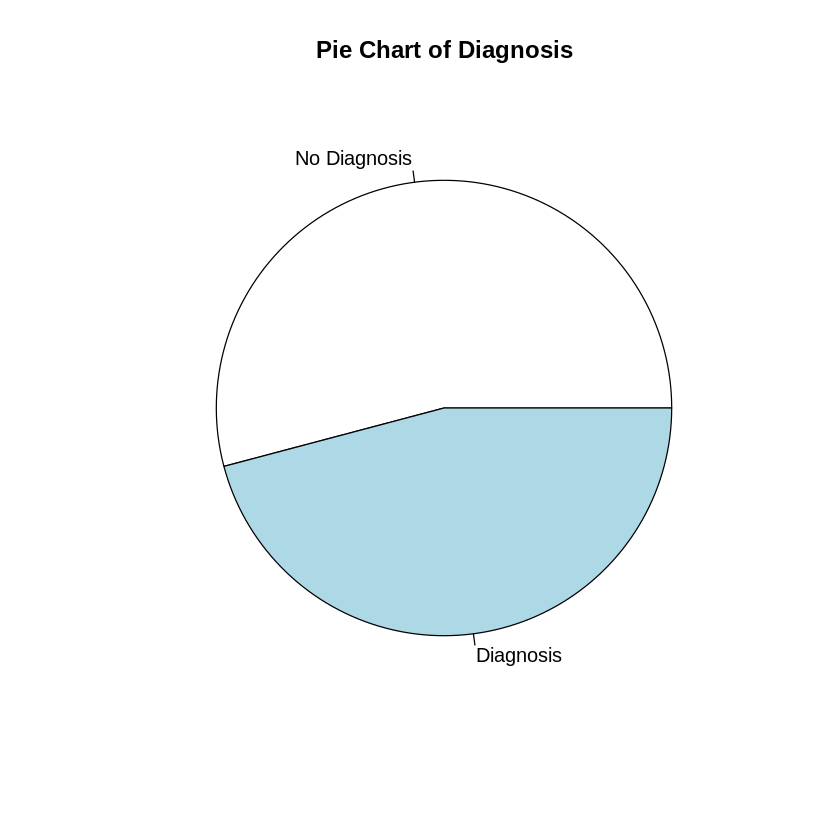

In [4]:
diagnosis_count <- heart_disease_data |>
    group_by(diagnosis) |>
    summarize(count = n()) |>
    pull(count)
    
diagnosis_pie <- pie(diagnosis_count, labels = c("No Diagnosis", "Diagnosis"), main = "Pie Chart of Diagnosis")

^^ good, needs explanation though?

### DISTRIBUTION OF PREDICTOR VARIABLES

**I BELIEVE WE HAVE THIS IN OUR PROPOSAL?**

### Splitting the Data

We now split the data into training and testing sets, using a proportion of 0.75 so that our training set will contain 75% of the data points and our testing set will contain 25%. We will also be using set.seed() to ensure that our results are reproducible.

In [5]:
set.seed(1000)

heart_split <- initial_split(heart_disease_data, prop = 0.75, strata = diagnosis)
heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

### Creating the Recipe and Model

We create a recipe to predict the diagnosis based on four different quantitative variables- age, maximum heart rate, cholesterol level and resting blood pressure. We standardize our data and set the mean of the variables equal to 0, & the standard deviation equal to 1. 
We will also create a k-nearest neighbors classification model using our training data, where we will tune our number of neighbors to find the best value of K. 

In [6]:
heart_recipe <- recipe(diagnosis ~ age + max_heart_rate + cholesterol_level + resting_blood_pressure, data = heart_training) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
              set_engine("kknn") |>
              set_mode("classification")


heart_recipe
knn_spec

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Operations:

Scaling for all_predictors()
Centering for all_predictors()

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


### Performing Cross-Validation

Now, we perform a 5-fold cross validation to determine the best value of K. We create a workflow with our recipe and model, and find the accuracy for different values of K. We finally determine the value of K with the largest accuracy. 

In [7]:
set.seed(123)

heart_vfold <- vfold_cv(heart_training, v = 5, strata = diagnosis)

gridvals <- tibble (neighbors = seq(from =1,to = 100, by=2)) 

knn_results <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = heart_vfold, grid = gridvals) |>
  collect_metrics()

### Visualizing Cross-Validation Results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
37,accuracy,binary,0.7009135,5,0.02498389,Preprocessor1_Model19
29,accuracy,binary,0.6922222,5,0.02412515,Preprocessor1_Model15
33,accuracy,binary,0.6876768,5,0.01941270,Preprocessor1_Model17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
5,accuracy,binary,0.6301757,5,0.012749967,Preprocessor1_Model03
1,accuracy,binary,0.5814625,5,0.006497259,Preprocessor1_Model01
3,accuracy,binary,0.5644752,5,0.035996296,Preprocessor1_Model02


[1] 37

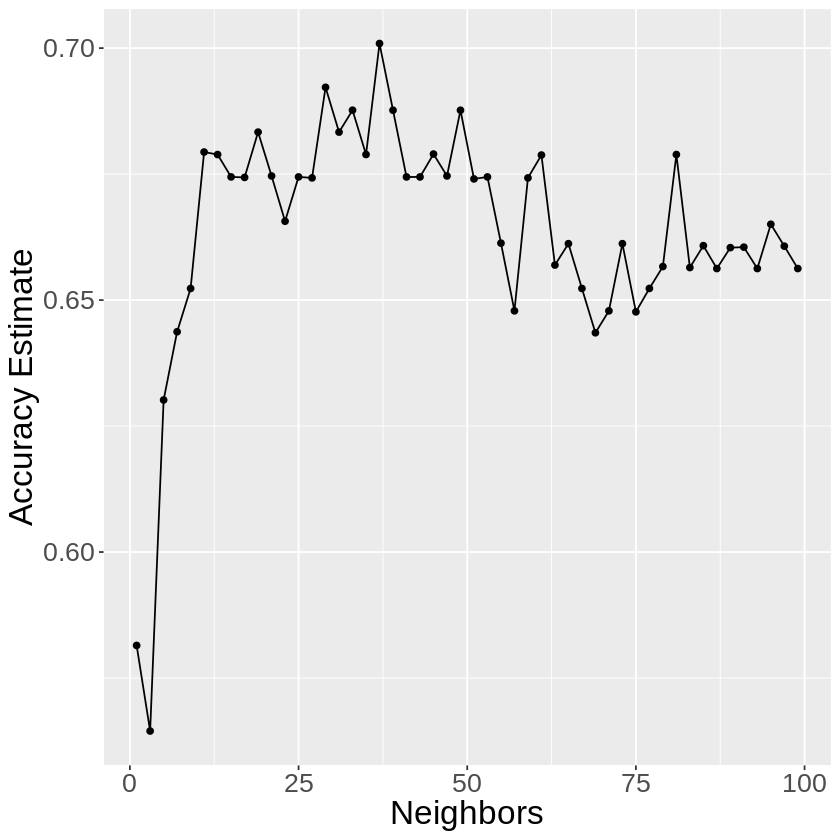

In [8]:
accuracies <- knn_results |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))

cross_val_plot <- accuracies |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 20))

k_best <- knn_results |>
   filter(.metric == "accuracy") |>
   arrange(.metric) |> 
   filter(mean == max(mean)) |>
   pull(neighbors)

cross_val_plot
accuracies
k_best

We can see above that k = 37 yields the best accuracy, with an accuracy of around 70%, while nearby values of k drop to around 67%. k = 37 also exists within a sort of "plateau" in accuracy, near the center of other elevated accuracy values.

## KNN Classification

Now that we have identified our best value of k, we can use it in a KNN Classification:

In [9]:
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 37) |>
              set_engine("kknn") |>
              set_mode("classification")

heart_disease_fit <- workflow() |>
        add_recipe(heart_recipe) |>
        add_model(knn_best_spec) |>
        fit(data=heart_training)

heart_predictions <- predict(heart_disease_fit, heart_testing) |>
                     bind_cols(heart_testing)

heart_metrics <- heart_predictions |>
                metrics(truth=diagnosis,estimate=.pred_class)

heart_metrics


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6447368
kap,binary,0.2835196


We can see above that k = 37 yields the best accuracy, with an accuracy of around 70%, while nearby values of k drop to around 67%. k = 37 also exists within a sort of "plateau" in accuracy, near the center of other elevated accuracy values.

### Re-training the model

Now that we have identified our best value of k, we can use it in a KNN Classification

In [10]:
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_best) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_best_fit <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_best_spec) |>
  fit(data = heart_training)

### Predicting on Testing Data and Calculating Accuracy Estimate

In [11]:
heart_test_predictions <- predict(knn_best_fit, heart_testing) |>
            bind_cols(heart_testing)

heart_metrics <- heart_test_predictions |>
            metrics(truth = diagnosis, estimate = .pred_class) |> 
            filter(.metric == "accuracy")

heart_metrics
heart_test_predictions

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6447368


.pred_class,age,sex,chest_pain_type,resting_blood_pressure,cholesterol_level,high_fasting_blood_sugar,resting_ecg_results,max_heart_rate,exercise_induced_angina,ST_depression_induced_by_exercise,slope_of_peak_exercise_ST_segment,num_blood_vessels_colored,thal,diagnosis_old,diagnosis
<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>
0,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0,0
0,56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0,0
0,62,0,4,140,268,0,2,160,0,3.6,3,2.0,3.0,3,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,58,1,4,114,318,0,1,140,0,4.4,3,3.0,6.0,4,1
0,45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0,1,1
1,68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,2,1


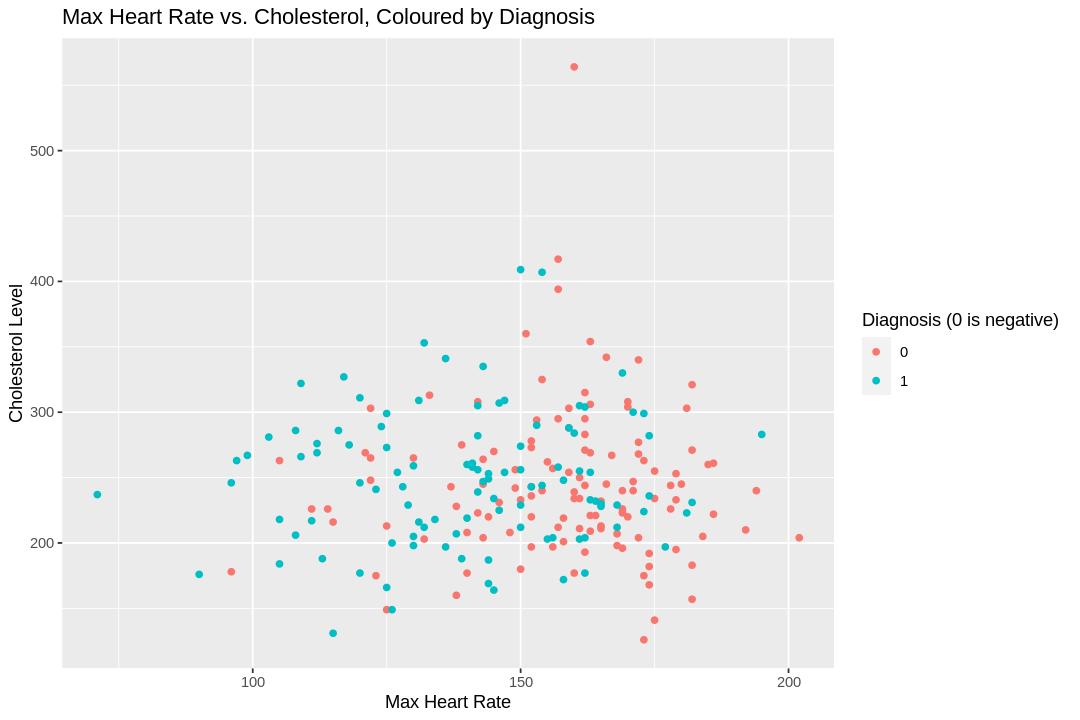

In [15]:
options(repr.plot.width = 9, repr.plot.height = 6)

cholesterol_plot <- heart_training |>
            ggplot(aes(x=max_heart_rate,y=cholesterol_level,color=diagnosis)) +
            geom_point() +
            ggtitle("Max Heart Rate vs. Cholesterol, Coloured by Diagnosis") +
            labs(x="Max Heart Rate",
                 y="Cholesterol Level",
                 color="Diagnosis (0 is negative)")
cholesterol_plot

In [20]:
# Code below adapted from section 5.8 of DSCI textbook

# create the grid of area/smoothness vals, and arrange in a data frame

hr_grid <- seq(min(heart_test_predictions$max_heart_rate), 
                max(heart_test_predictions$max_heart_rate), 
                length.out = 100)
chol_grid <- seq(min(heart_test_predictions$cholesterol_level), 
                max(heart_test_predictions$cholesterol_level), 
                length.out = 100)

asgrid <- as_tibble(expand.grid(max_heart_rate = hr_grid,
                                cholesterol_level = chol_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(knn_best_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) |> 
  rename(Class = .pred_class)

# plot:
# 1. the colored scatter of the original data
# 2. the faded colored scatter for the grid points
wkflw_plot <-
  ggplot() +
  geom_point(data = heart_test_predictions, 
             mapping = aes(x = max_heart_rate, 
                           y = cholesterol_level, 
                           color = Class), 
             alpha = 0.75) +
  geom_point(data = prediction_table, 
             mapping = aes(x = max_heart_rate, 
                           y = cholesterol_level, 
                           color = Class), 
             alpha = 0.02, 
             size = 5) +
  labs(color = "Diagnosis", 
       x = "Max Heart Rate (standardized)", 
       y = "Cholesterol Level (standardized)") +
  scale_color_manual(labels = c("Yes", "No"), 
                     values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 12))

wkflw_plot


### IF ANY CAN FIGURE OUT HOW TO MAKE WORK W OUR 5 PREDICTORS, PLS DO THANK U THANK U

ERROR: [1m[33mError[39m in [1m[1m`validate_column_names()`:[22m
[33m![39m The following required columns are missing: 'age', 'resting_blood_pressure'.



visualize results here

## Discussion

stuff from proposal, plus conclusions drawn from data

## References


At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
Make sure to cite the source of your data as well.

Dataset Source:

https://archive.ics.uci.edu/ml/datasets/Heart+Disease


Thomas, Jen. Heart Disease: Facts, Statistics and You. Healthline.

https://www.healthline.com/health/heart-disease/statistics#Who-is-at-risk

**NEED ONE MORE ARTICLE CITATION, maybe in discussion?**